# PID Classification with Neural Networks (Unsupervised Training)

This example illustrates the classification of particle types using [tensorflow](https://www.tensorflow.org/)/[neupy](http://neupy.com/pages/home.html) neural networks. The unsupervised training uses a Growing Neural Gas (GNG) model with MC generated data of [BaBar](https://www.flickr.com/photos/slaclab/46211844232). As the training might take a very long time, it is possible to persist a network and read the trained network for data analytics.

We begin with the standard imports. This notebook uses numpy, pandas, seaborn, matplotlib, and tensorflow/keras. The data are read from a ROOT file with uproot:

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import uproot

print(tf.__version__)

/Users/marcel/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/marcel/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/marcel/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/marcel/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework

1.13.2


# Training Dataset
We are reading the training dataset from a ROOT file. The file contains particle momentum (mom) and track elevation (theta), dE/dx measurement from silicon vertex tracker (svt) and drift chamber (dch), as well as energy deposit in the electromagnetic calorimeter (emc), the cerenkov angle in the DIRC (drc), and the hit patterns in the instrumented flux return (ifr). The file in addition holds higher level features like partial energy sums, zernicke momenta, likelihood etc. 

The particles are labeled (id)
* Electron = 0
* Muon = 1
* Pion = 2
* Kaon = 3
* Proton = 4

In [2]:
target_names = ['Electron', 'Muon', 'Pion', 'Kaon', 'Proton']

In [3]:
file = uproot.open("pid.root")

In [4]:
file.keys()

[b'PidTuple;1']

In [5]:
tree = file["PidTuple"]
tree.keys()

[b'mom',
 b'theta',
 b'svt',
 b'emc',
 b'drc',
 b'dch',
 b'ifr',
 b'ifrExp',
 b'ifrAdd',
 b'ifrStrip',
 b'ifrFirst',
 b'ifrLast',
 b'emcS1S9',
 b'emcS9S25',
 b'emczern20',
 b'emczern40',
 b'emclat',
 b'charge',
 b'drcnphot',
 b'emcphi',
 b'emctheta',
 b'pid',
 b'lipisvt',
 b'limusvt',
 b'likasvt',
 b'lipidch',
 b'limudch',
 b'likadch',
 b'lipidrc',
 b'limudrc',
 b'likadrc',
 b'lipiemc',
 b'limuemc',
 b'likaemc',
 b'lipiifr',
 b'limuifr',
 b'likaifr',
 b'charge',
 b'id']

In [6]:
tree.numentries

83826

We assemble the training dataset as a pandas dataframe and plot the particle statistics:

In [7]:
data = tree.arrays(["id", "mom", "theta", "svt", "emc", "drc", "dch", "ifr"])
dataset = pd.DataFrame(data)
dataset.tail()

,b'id',b'mom',b'theta',b'svt',b'emc',b'drc',b'dch',b'ifr'
83821,4,1.156832,0.842868,5.810547,0.365639,0.495674,732.421875,0.000000
83822,4,2.320551,0.914929,4.296875,1.259613,0.749020,537.109375,0.000000
83823,4,1.881898,0.807030,4.589844,0.164413,0.710582,454.101562,2.352941
83824,4,1.998565,0.996907,3.564453,0.463104,0.721126,444.335938,3.019608
83825,4,0.995329,0.923367,6.005859,0.354385,0.364935,771.484375,0.000000


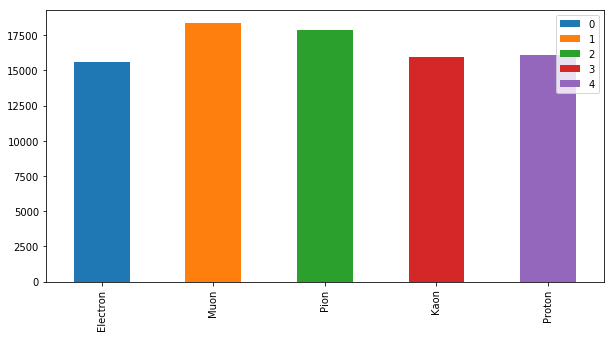

In [8]:
electron = dataset[dataset[b'id']==0][b'id'].value_counts()
muon = dataset[dataset[b'id']==1][b'id'].value_counts()
pion = dataset[dataset[b'id']==2][b'id'].value_counts()
kaon = dataset[dataset[b'id']==3][b'id'].value_counts()
proton = dataset[dataset[b'id']==4][b'id'].value_counts()

df = pd.DataFrame([electron, muon, pion, kaon, proton])
df.index = target_names
df.plot(kind='bar',stacked=True, figsize=(10,5))

# Data Preparation
We generate a training dataset (90%) and a test dataset (10%) from the input dataset. The vectors are shuffled in random order.

In [9]:
train_dataset = dataset.sample(frac=0.9,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

Show a correlation matrix of the feature vector:

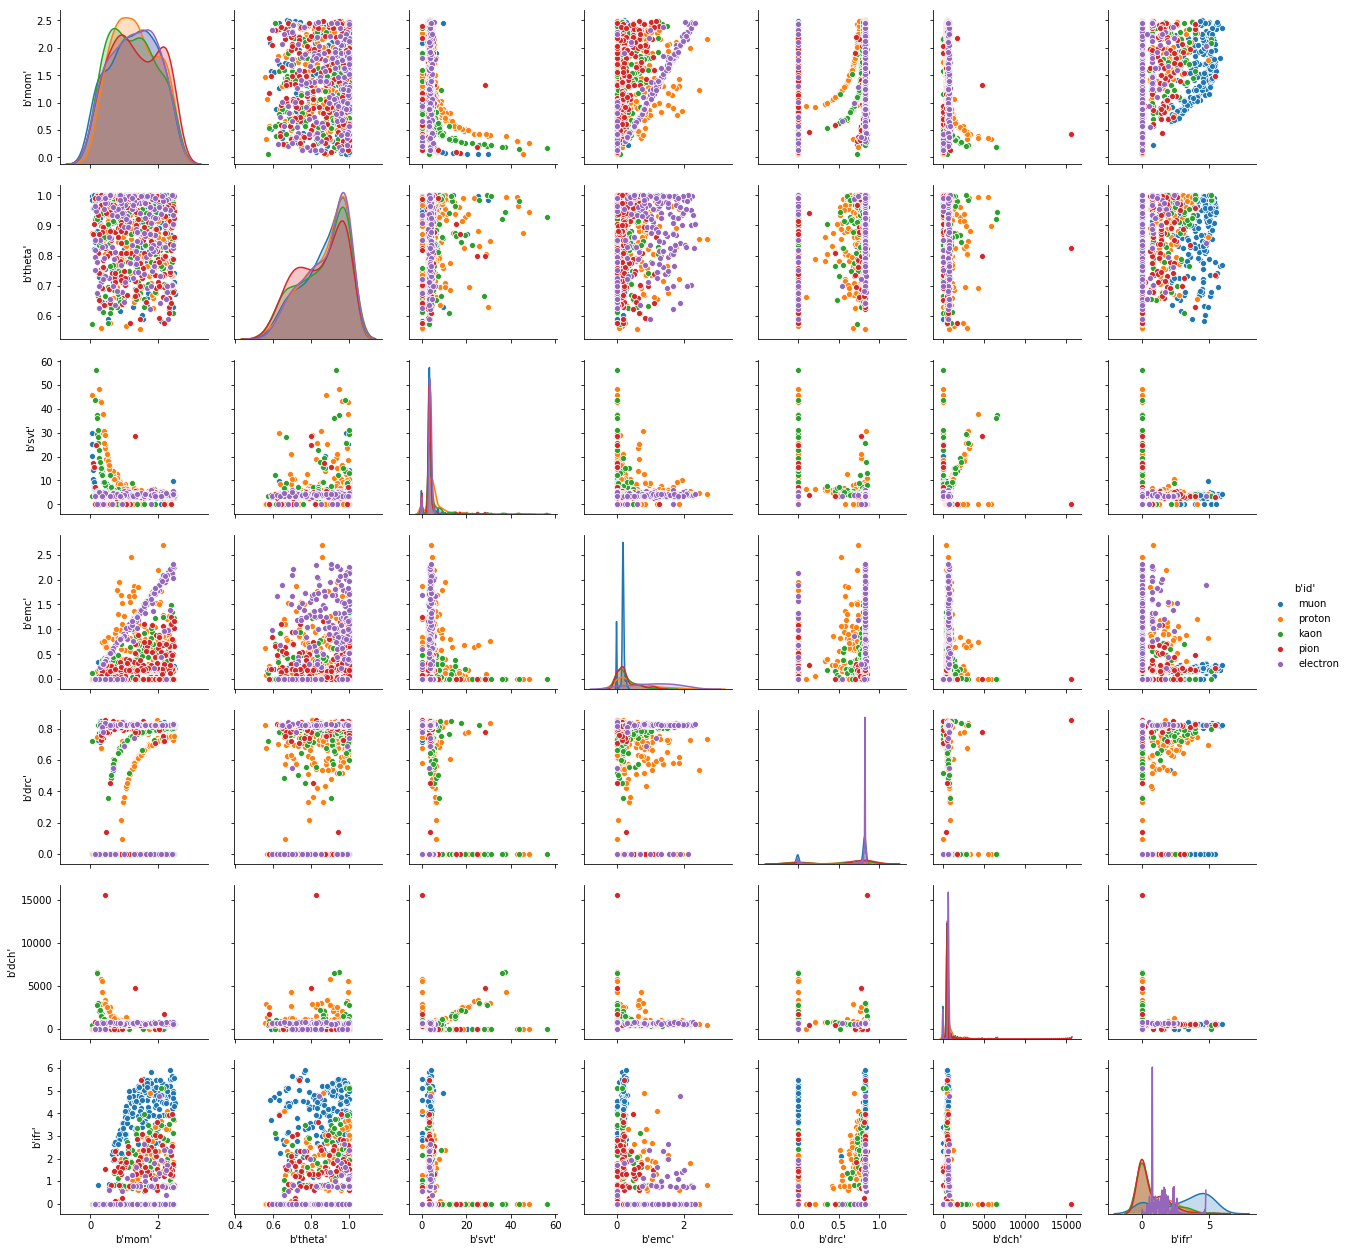

In [10]:
train = train_dataset[[b'mom', b'theta', b'svt', b'emc', b'drc', b'dch', b'ifr', b'id']]
train[b'id'] = train[b'id'].map( {0: 'electron', 1: 'muon', 2: 'pion', 3:'kaon', 4:'proton'} ).astype(str)
sns.pairplot(data=train[:1000], hue=b'id', diag_kind="kde")
plt.show()

We extract the particle labels to be used for particle tagging:

In [11]:
train_labels = train_dataset.pop(b'id')
test_labels = test_dataset.pop(b'id')

We normalize the training and test vectors:

In [12]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
b'mom',75443.0,1.306043,0.688871,0.050066,0.720069,1.303027,1.899939,4.373626
b'theta',75443.0,0.868458,0.117722,0.540726,0.778496,0.900688,0.974906,1.000000
b'svt',75443.0,4.900804,5.308939,0.000000,3.320312,3.759766,4.492188,94.531250
b'emc',75443.0,0.436460,0.534734,0.000000,0.150585,0.203514,0.566483,3.915405
b'drc',75443.0,0.570131,0.351876,0.000000,0.000000,0.792004,0.820806,0.864134
b'dch',75443.0,605.947021,576.025208,0.000000,473.632812,537.109375,634.765625,17812.500000
b'ifr',75443.0,1.166395,1.620633,0.000000,0.000000,0.000000,2.039216,6.980392


In [13]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## 1. Build and train the GNG Model
The keras model implements a neural network with two hidden layers. The input feature vector represents measured detector quantities as defined above. The output reflects the particle probabilities.

In [14]:
from neupy import algorithms, utils
def build_model(dimension, max_nodes=100, step=0.5, n_start_nodes=2, max_edge_age=15):
    model = algorithms.GrowingNeuralGas(
        n_inputs=dimension,
        n_start_nodes=n_start_nodes,

        shuffle_data=True,
        verbose=True,

        step=step,
        neighbour_step=0.05,

        max_edge_age=max_edge_age,
        max_nodes=max_nodes,

        n_iter_before_neuron_added=10,
        after_split_error_decay_rate=0.1,
        error_decay_rate=0.995,
        min_distance_for_update=0.01,
    )
    return model

In [15]:
model = build_model(len(train_dataset.keys()))


Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] after_split_error_decay_rate = 0.1
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 15
[OPTION] max_nodes = 100
[OPTION] min_distance_for_update = 0.01
[OPTION] n_inputs = 7
[OPTION] n_iter_before_neuron_added = 10
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.05
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] signals = None
[OPTION] step = 0.5
[OPTION] verbose = True



Train the GNG network (This might take a _very_ long time, depending on your CPU power). Draw the GNG network for each iteration.

In [16]:
utils.reproducible()
for epoch in range(10):
    model.train(train_dataset, epochs=1)

#1 : [13 sec] train: 6.159141


#2 : [13 sec] train: 5.153991


#3 : [13 sec] train: 5.208479


#4 : [14 sec] train: 5.133035


#5 : [13 sec] train: 5.149026


#6 : [14 sec] train: 5.158840


#7 : [13 sec] train: 5.100524


#8 : [13 sec] train: 5.104776


#9 : [13 sec] train: 5.078007
#10 : [14 sec] train: 5.119363


Save the GNG network

In [17]:
import dill
with open('gng.dill', 'wb') as f:
    dill.dump(model, f)

## 2. Analyze the GNG Network
We identify the clusters in the network that represent the particle types. 

In [18]:
import dill
with open('gng.dill', 'rb') as f:
    model = dill.load(f)

In [19]:
len(model.graph.nodes)

100

In [20]:
len(model.graph.edges)

97

Run a k-means algorithm to identify clusters of nodes. We use 5 categories as we have 5 particle types:

In [21]:
from sklearn.cluster import KMeans
train = train_dataset.to_numpy()
nodes = model.graph.nodes
weights = np.concatenate([node.weight for node in nodes])
kmeans = KMeans(n_clusters=5, random_state=0).fit(weights)
kpred_labels = kmeans.predict(train)
kpredictions = tf.keras.utils.to_categorical(weights)

In [22]:
def winner_node(graph,sample,n=1):
    nodes = graph.nodes
    weights = np.concatenate([node.weight for node in nodes])
    distance = np.linalg.norm(weights - sample, axis=1)
    neuron_ids = np.argsort(distance)
    closest_neuron_id = neuron_ids[0:n]
    return closest_neuron_id

In [23]:
def node_distance(graph,sample):
    nodes = graph.nodes
    weights = np.concatenate([node.weight for node in nodes])
    distance = np.linalg.norm(weights - sample, axis=1)
    neuron_ids = np.argsort(distance)
    closest_neuron_id, second_closest_id = neuron_ids[:2]
    closest_neuron = nodes[closest_neuron_id]
    second_closest = nodes[second_closest_id]
    total_error = 0
    for to_neuron in list(graph.edges_per_node[closest_neuron]): 
        edge_id = graph.find_edge_id(to_neuron, closest_neuron)
        #print(edge_id)
        total_error += distance[graph.edges[edge_id]] 
    return closest_neuron_id,total_error

In order to determine the responsibility of the graph nodes wrt. a certain hypothesis we assign the training labels to the corresponding winner nodes of the training data. This is achieved by fillling a 2D histogram with the winner nodes vs. the training labels.

In [24]:
bestmatches = 2
labels  = np.repeat(train_labels,bestmatches)
winners = np.arange(0)
for sample in train:
    winners = np.append(winners, winner_node(model.graph,sample,bestmatches))

It seems that winner nodes are peaking at different locations for the various particle types.

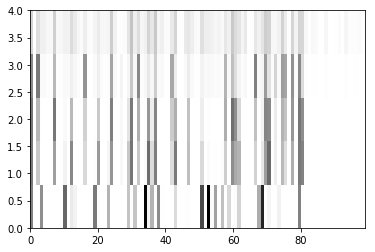

In [25]:
#labels = np.repeat(train_labels,bestmatches)
histogram, xedges, yedges = np.histogram2d(winners,labels,bins=(len(model.graph.nodes),5))
plt.hist2d(winners,labels,bins=(len(model.graph.nodes),5),cmap='Greys')
plt.show()

In order to make a prediction for a sample feature vector of the test dataset we determine the histogram counts for each particle hypothesis and transform the five values to a softmax probability vector.

In [26]:
def predict(graph,sample,histogram):
    w = winner_node(graph,sample)[0]  # winner_node returns a list of the first n winners, default is n=1
    pred = np.array(histogram[w])  # [el, mu, pi, ka, pr]
    pred /= (np.amax(pred) + 1.e-6)
    pexp = np.exp(pred)
    return pexp / np.sum(pexp)  # softmax

In [27]:
test = test_dataset.to_numpy()
pred_labels = np.arange(0)
predictions = np.arange(0)
for sample in test:
    prediction = predict(model.graph,sample,histogram)
    predictions = np.append(predictions, prediction)
    label = np.where(prediction == np.amax(prediction))
    pred_labels = np.append(pred_labels, label[0][0]) # Take only the first element in case of ambiguities

predictions = np.reshape(predictions, (-1, 5))
#predictions = to_categorical(pred_labels)

In [28]:
predictions

array([[0.35763973, 0.13581893, 0.13517269, 0.15871744, 0.21265121],
       [0.13103703, 0.30693528, 0.2427702 , 0.14821767, 0.17103983],
       [0.38745605, 0.1471809 , 0.14568264, 0.15270339, 0.16697702],
       ...,
       [0.09924167, 0.23324828, 0.26742275, 0.23206385, 0.16802344],
       [0.1050257 , 0.27879554, 0.26699043, 0.17081777, 0.17837056],
       [0.13991737, 0.13991737, 0.14416985, 0.19566057, 0.38033484]])

## 3. Model Evaluation
We evaluate the model performance using the mormalized test data set and compare the output vector to the test labels. The output vector holds the probabilities of the five particle hypotheses.

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
#pred_labels = np.argmax(predictions, axis=1)
print(confusion_matrix(test_labels, pred_labels))

[[1271  103  175    1   38]
 [ 174  811  540  334    3]
 [  92  651  565  405   11]
 [ 149  257  472  575  111]
 [ 282  368  276  226  493]]


In [30]:
print(classification_report(test_labels, pred_labels, target_names=target_names))

              precision    recall  f1-score   support

    Electron       0.65      0.80      0.71      1588
        Muon       0.37      0.44      0.40      1862
        Pion       0.28      0.33      0.30      1724
        Kaon       0.37      0.37      0.37      1564
      Proton       0.75      0.30      0.43      1645

   micro avg       0.44      0.44      0.44      8383
   macro avg       0.48      0.45      0.44      8383
weighted avg       0.48      0.44      0.44      8383



## 4. Physics Control Plots

We inspect the results by plotting the measured data in dependance of the particle momentum. The color index is: protons (yellow), kaons (green), pions (cyan), muons (blue), electrons (red).

In [31]:
mom = test_dataset[b'mom']
svt = test_dataset[b'svt']
emc = test_dataset[b'emc']
dch = test_dataset[b'dch']
drc = test_dataset[b'drc']
ifr = test_dataset[b'ifr']

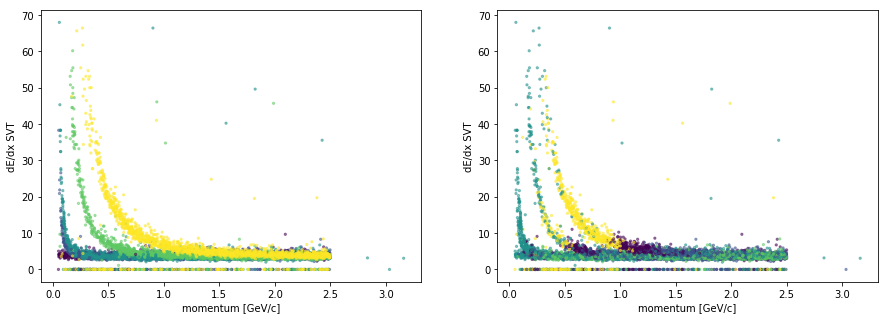

In [32]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(mom, svt, alpha=0.5,
            s=5, c=test_labels, cmap='viridis')
plt.ylabel('dE/dx SVT')
plt.xlabel('momentum [GeV/c]')
plt.subplot(1,2,2)
plt.scatter(mom, svt, alpha=0.5,
            s=5, c=pred_labels, cmap='viridis')
plt.ylabel('dE/dx SVT')
plt.xlabel('momentum [GeV/c]')
plt.show()

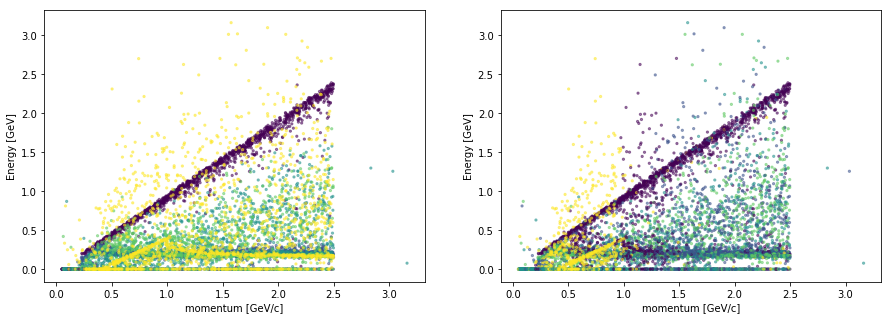

In [33]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(mom, emc, alpha=0.5,
            s=5, c=test_labels, cmap='viridis')
plt.ylabel('Energy [GeV]')
plt.xlabel('momentum [GeV/c]')
plt.subplot(1,2,2)
plt.scatter(mom, emc, alpha=0.5,
            s=5, c=pred_labels, cmap='viridis')
plt.ylabel('Energy [GeV]')
plt.xlabel('momentum [GeV/c]')
plt.show()

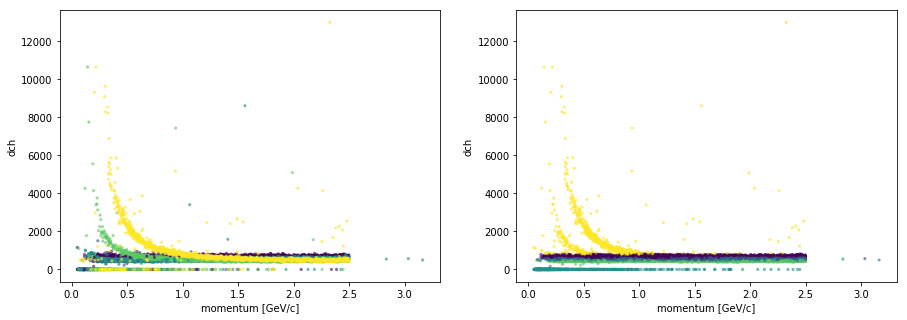

In [34]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(mom, dch, alpha=0.5,
            s=5, c=test_labels, cmap='viridis')
plt.ylabel('dch')
plt.xlabel('momentum [GeV/c]')
plt.subplot(1,2,2)
plt.scatter(mom, dch, alpha=0.5,
            s=5, c=pred_labels, cmap='viridis')
plt.ylabel('dch')
plt.xlabel('momentum [GeV/c]')
plt.show()

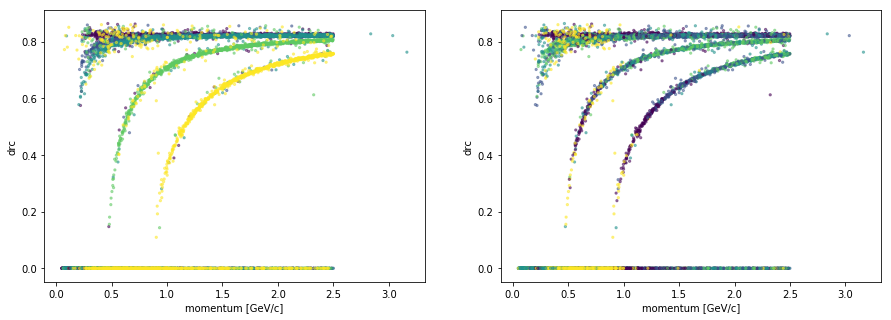

In [35]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(mom, drc, alpha=0.5,
            s=5, c=test_labels, cmap='viridis')
plt.ylabel('drc')
plt.xlabel('momentum [GeV/c]')
plt.subplot(1,2,2)
plt.scatter(mom, drc, alpha=0.5,
            s=5, c=pred_labels, cmap='viridis')
plt.ylabel('drc')
plt.xlabel('momentum [GeV/c]')
plt.show()

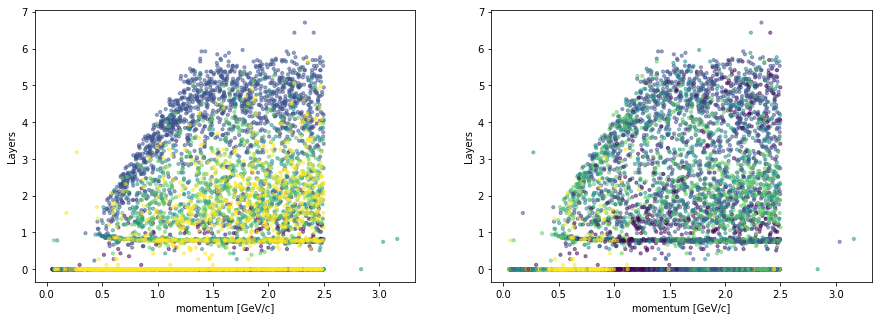

In [36]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(mom, ifr, alpha=0.5,
            s=10, c=test_labels, cmap='viridis')
plt.ylabel('Layers')
plt.xlabel('momentum [GeV/c]')
plt.subplot(1,2,2)
plt.scatter(mom, ifr, alpha=0.5,
            s=10, c=pred_labels, cmap='viridis')
plt.ylabel('Layers')
plt.xlabel('momentum [GeV/c]')
plt.show()

## Muon Selection
By inspection of the physics control plots it seems difficult to clearly separate muons (blue) from pions (cyan) by simple linear cuts. Thus we want to construct a muon selector based on the network output respecting the probability of the five particle hypotheses. Taking into account the relative a priori probabilities of the particle occurence we can formulate a likelihood ratio to observe a muon (Pions are 5 times more abundant than muons, protons occur at 10% only).

In [37]:
electron = predictions[:,0]
muon     = predictions[:,1]
pion     = predictions[:,2] * 5.0
kaon     = predictions[:,3]
proton   = predictions[:,4] * 0.1

In [38]:
L = np.log(muon) - np.log(pion)

If we plot L = log(muon) - log(pion) we are able to clearly separate muons by a cut on L > -2.0 over a wide momentum range.

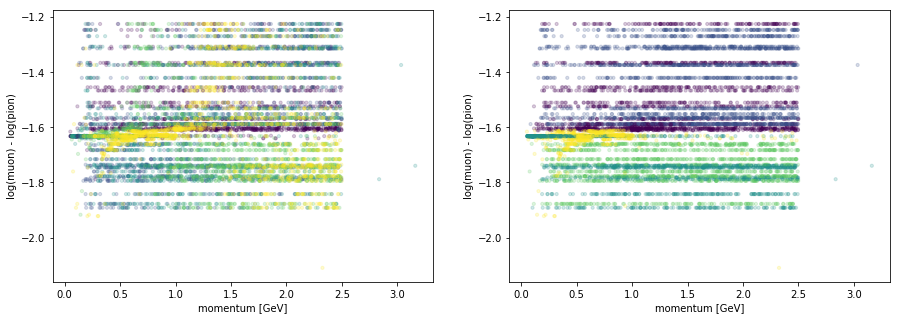

In [39]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(mom, L, alpha=0.2,
            s=10, c=test_labels, cmap='viridis')
plt.ylabel('log(muon) - log(pion)')
plt.xlabel('momentum [GeV]')
plt.subplot(1,2,2)
plt.scatter(mom, L, alpha=0.2,
            s=10, c=pred_labels, cmap='viridis')
plt.ylabel('log(muon) - log(pion)')
plt.xlabel('momentum [GeV]')
plt.show()